In [1]:
import tensorflow as tf
import tfx

ModuleNotFoundError: No module named 'tensorflow'

# Setup

In [142]:
!pip install torchaudio

  Using cached torch-1.11.0-cp38-cp38-win_amd64.whl (158.0 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.8.1
    Uninstalling torch-1.8.1:
      Successfully uninstalled torch-1.8.1


In [237]:
from pathlib import Path
import os, pandas as pd
from fastcore.all import *
import torch
import torchaudio

In [238]:
NB_DIR = Path.cwd()
#LOCAL_DATA = NB_DIR/'..'/'data'
DATA = Path('C://Users/Jens/Documents/V22/DAT255/data')
AUDIO_TAGGING = DATA/'freesound-audio-tagging'

In [239]:
from fastai.vision.all import *


In [240]:
AUDIO_TAGGING.ls()

(#6) [Path('C:/Users/Jens/Documents/V22/DAT255/data/freesound-audio-tagging/audio_test'),Path('C:/Users/Jens/Documents/V22/DAT255/data/freesound-audio-tagging/audio_train'),Path('C:/Users/Jens/Documents/V22/DAT255/data/freesound-audio-tagging/sample_submission.csv'),Path('C:/Users/Jens/Documents/V22/DAT255/data/freesound-audio-tagging/test_post_competition.csv'),Path('C:/Users/Jens/Documents/V22/DAT255/data/freesound-audio-tagging/train.csv'),Path('C:/Users/Jens/Documents/V22/DAT255/data/freesound-audio-tagging/train_post_competition.csv')]

# Loading data

In [241]:
df = pd.read_csv(AUDIO_TAGGING/'train.csv')
df.head()

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1


In [242]:
df.shape

(9473, 3)

In [243]:
labels = df.label.unique()
print(labels)
print(len(labels))

['Hi-hat' 'Saxophone' 'Trumpet' 'Glockenspiel' 'Cello' 'Knock'
 'Gunshot_or_gunfire' 'Clarinet' 'Computer_keyboard' 'Keys_jangling'
 'Snare_drum' 'Writing' 'Laughter' 'Tearing' 'Fart' 'Oboe' 'Flute' 'Cough'
 'Telephone' 'Bark' 'Chime' 'Bass_drum' 'Bus' 'Squeak' 'Scissors'
 'Harmonica' 'Gong' 'Microwave_oven' 'Burping_or_eructation' 'Double_bass'
 'Shatter' 'Fireworks' 'Tambourine' 'Cowbell' 'Electric_piano' 'Meow'
 'Drawer_open_or_close' 'Applause' 'Acoustic_guitar' 'Violin_or_fiddle'
 'Finger_snapping']
41


In [244]:
AUDIO_DIR = AUDIO_TAGGING/'audio_train'
IMG_DIR = DATA/'imgs'
!mkdir {IMG_DIR} -p

A subdirectory or file C:\Users\Jens\Documents\V22\DAT255\data\imgs already exists.
Error occurred while processing: C:\Users\Jens\Documents\V22\DAT255\data\imgs.
A subdirectory or file -p already exists.
Error occurred while processing: -p.


In [245]:
AUDIO_DIR.ls()

(#9473) [Path('C:/Users/Jens/Documents/V22/DAT255/data/freesound-audio-tagging/audio_train/00044347.wav'),Path('C:/Users/Jens/Documents/V22/DAT255/data/freesound-audio-tagging/audio_train/001ca53d.wav'),Path('C:/Users/Jens/Documents/V22/DAT255/data/freesound-audio-tagging/audio_train/002d256b.wav'),Path('C:/Users/Jens/Documents/V22/DAT255/data/freesound-audio-tagging/audio_train/0033e230.wav'),Path('C:/Users/Jens/Documents/V22/DAT255/data/freesound-audio-tagging/audio_train/00353774.wav'),Path('C:/Users/Jens/Documents/V22/DAT255/data/freesound-audio-tagging/audio_train/003b91e8.wav'),Path('C:/Users/Jens/Documents/V22/DAT255/data/freesound-audio-tagging/audio_train/003da8e5.wav'),Path('C:/Users/Jens/Documents/V22/DAT255/data/freesound-audio-tagging/audio_train/0048fd00.wav'),Path('C:/Users/Jens/Documents/V22/DAT255/data/freesound-audio-tagging/audio_train/004ad66f.wav'),Path('C:/Users/Jens/Documents/V22/DAT255/data/freesound-audio-tagging/audio_train/0063ab88.wav')...]

# Exploring the data

In [246]:
from IPython.display import Audio
import librosa
import librosa.display

In [247]:
fnames = os.listdir(str(AUDIO_DIR))
len(fnames), fnames[:5]

(9473,
 ['00044347.wav',
  '001ca53d.wav',
  '002d256b.wav',
  '0033e230.wav',
  '00353774.wav'])

In [248]:
fn = fnames[40]
label = df.loc[df['fname'].eq(fn), 'label'].iloc[0]
print(label)
Audio(str(AUDIO_DIR/fn))

Clarinet


In [249]:
x, sample_rate = librosa.load(AUDIO_DIR/fn)
x.shape, sample_rate, x.dtype

((113337,), 22050, dtype('float32'))

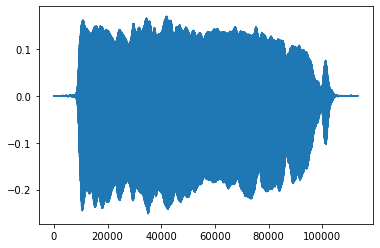

In [250]:
plt.plot(x)

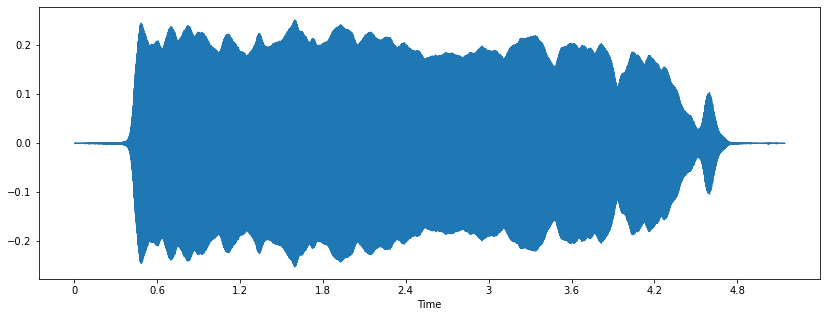

In [251]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sample_rate)

In [255]:
def log_mel_spec_tfm(fname, src_path, dst_path):
    x, sample_rate = librosa.load(src_path/fname)
    
    n_fft = 1024
    hop_length = 512
    n_mels = 80
    fmin = 20
    fmax = sample_rate / 2 
    
    mel_spec_power = librosa.feature.melspectrogram(x, sr=sample_rate, n_fft=n_fft, 
                                                    hop_length=hop_length, 
                                                    n_mels=n_mels, power=2.0, 
                                                    fmin=fmin, fmax=fmax)
    
    #mel_spec_power = librosa.feature.melspectrogram(x, sr=sample_rate)
    
    mel_spec_db = librosa.power_to_db(mel_spec_power, ref=np.max)
    
    label = df.loc[df['fname'].eq(fn), 'label'].iloc[0]
    
    dst_path = dst_path / label
    dst_path.mkdir(exist_ok=True)
    
    dst_fname = dst_path / (fname[:-4] + '.png')
    plt.imsave(dst_fname, mel_spec_db)

<ipython-input-255-207bae564497>:10: FutureWarning: Pass y=[ 1.6816542e-04  2.7756288e-04  1.9488559e-04 ... -2.2358532e-05
 -1.7488443e-05  6.2328600e-06] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_spec_power = librosa.feature.melspectrogram(x, sr=sample_rate, n_fft=n_fft,


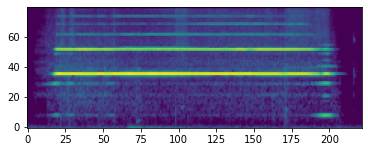

In [256]:
log_mel_spec_tfm(fn, AUDIO_DIR, IMG_DIR)
img = plt.imread(str(IMG_DIR/(fn[:-4] + '.png')))
plt.imshow(img, origin='lower');

In [151]:
#waveform, sr = torchaudio.load(AUDIO_DIR/fn)

In [152]:
# def show_melspectrogram(waveform,sample_rate):
#     mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate)(waveform)
#     print("Shape of spectrogram: {}".format(mel_spectrogram.size()))

#     plt.figure()
#     plt.imshow(mel_spectrogram.log2()[0,:,:].numpy(), cmap='viridis')

Shape of spectrogram: torch.Size([1, 128, 2929])


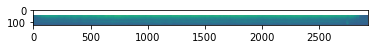

In [153]:
#show_melspectrogram(waveform, sr)

In [253]:
for i in AUDIO_DIR.iterdir():
    log_mel_spec_tfm(fn, AUDIO_DIR, IMG_DIR)

<ipython-input-252-3ef42b625ed5>:10: FutureWarning: Pass y=[ 1.6816542e-04  2.7756288e-04  1.9488559e-04 ... -2.2358532e-05
 -1.7488443e-05  6.2328600e-06] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_spec_power = librosa.feature.melspectrogram(x, sr=sample_rate, n_fft=n_fft,


KeyboardInterrupt: 